### Install (Conda required)
conda create -n coiled-datashader -c conda-forge python=3.10 coiled dask s3fs pyarrow datashader hvplot jupyter_bokeh

%conda activate coiled-datashader

In [1]:
%pip install coiled dask s3fs pyarrow datashader hvplot jupyter_bokeh --user

     ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
     ---------- ----------------------------- 0.4/1.4 MB 7.6 MB/s eta 0:00:01
     --------------------------- ------------ 1.0/1.4 MB 10.0 MB/s eta 0:00:01
     ---------------------------------------- 1.4/1.4 MB 9.8 MB/s eta 0:00:00
     ---------------------------------------- 0.0/162.7 kB ? eta -:--:--
     -------------------------------------- 162.7/162.7 kB 9.5 MB/s eta 0:00:00
  Using cached httpx-0.25.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached ipywidgets-8.1.1-py3-none-any.whl.metadata (2.4 kB)
  Using cached prometheus_client-0.18.0-py3-none-any.whl.metadata (26 kB)
  Using cached wheel-0.41.3-py3-none-any.whl.metadata (2.2 kB)
     ---------------------------------------- 0.0/55.8 kB ? eta -:--:--
     ---------------------------------------- 55.8/55.8 kB ? eta 0:00:00
     ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
     ------------------- -------------------- 0.8/1.7 MB 2

In [2]:
# Read in one year of NYC Taxi data
import dask.dataframe as dd

df = dd.read_parquet(
    "s3://coiled-datasets/dask-book/nyc-tlc/2009",
    storage_options={"anon": True},
)
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1,2.63,-73.991957,40.721567,NaN,<NA>,-73.993803,40.695922,CASH,8.9,0.5,NaN,0.00,0.0,9.40
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3,4.55,-73.982102,40.736290,NaN,<NA>,-73.955850,40.768030,Credit,12.1,0.5,NaN,2.00,0.0,14.60
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5,10.35,-74.002587,40.739748,NaN,<NA>,-73.869983,40.770225,Credit,23.7,0.0,NaN,4.74,0.0,28.44
3,DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1,5.00,-73.974267,40.790955,NaN,<NA>,-73.996558,40.731849,CREDIT,14.9,0.5,NaN,3.05,0.0,18.45
4,DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1,0.40,-74.001580,40.719382,NaN,<NA>,-74.008378,40.720350,CASH,3.7,0.0,NaN,0.00,0.0,3.70


In [3]:
len(df)

170896055

In [4]:
%%time

df.sample(frac=0.001).compute().plot(
    x="pickup_longitude", 
    y="pickup_latitude", 
    kind="scatter",
)

KeyboardInterrupt: 

In [5]:
import datashader
from datashader import transfer_functions as tf
from datashader.colors import Hot
import holoviews as hv



def render(df, x_range=(-74.1, -73.7), y_range=(40.6, 40.9)):
    # Plot
    canvas = datashader.Canvas(
        x_range=x_range,
        y_range=y_range,
    )
    agg = canvas.points(
        source=df, 
        x="dropoff_longitude", 
        y="dropoff_latitude", 
        agg=datashader.count("passenger_count"),
    )
    return datashader.transfer_functions.shade(agg, cmap=Hot, how="eq_hist")

%%time
render(df)


UsageError: Line magic function `%%time` not found.


In [6]:
# load dataset into cluster memory
df.persist()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
npartitions=876,,,,,,,,,,,,,,,,,,
,string,datetime64[us],datetime64[us],int64,float64,float64,float64,float64,string,float64,float64,string,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


CPU times: total: 40.4 s
Wall time: 3min 24s


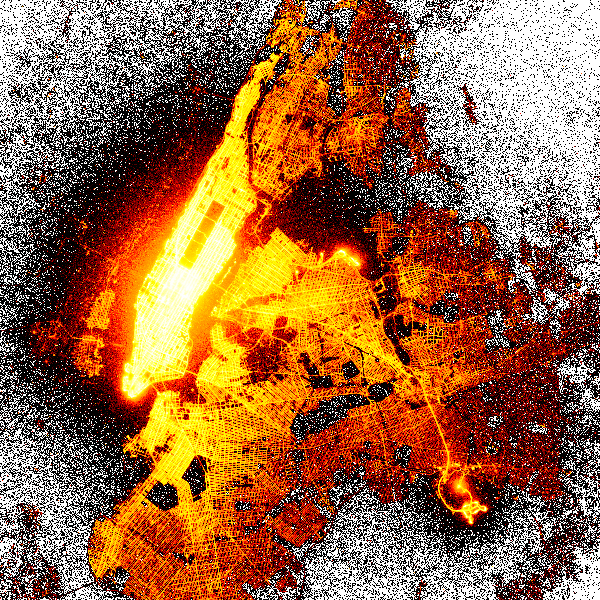

In [7]:
%%time
render(df)

In [8]:
import hvplot.dask
 
def interact(df):
    return df.hvplot.scatter(
        x="dropoff_longitude", 
        y="dropoff_latitude", 
        aggregator=datashader.count("passenger_count"), 
        datashade=True, cnorm="eq_hist", cmap=Hot,
        width=600, 
        height=400,
    )
 
interact(df)

BokehModel(combine_events=True, render_bundle={'docs_json': {'ba31a936-e29a-4a3e-b02f-10e28133d56e': {'version…